In [140]:
# importing modules
import os
import pip
!python -m pip install mne
os.system('python -m pip install scikit-learn')
import numpy as np
import pandas as pd
import mne
from scipy import stats as st
import statistics as stats
from itertools import combinations

!python -m pip install statsmodels
from statsmodels.stats.multitest import multipletests as multi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 KB 5.8 MB/s eta 0:00:00a 0:00:01


In [91]:
all_epochs = mne.read_epochs('group5_epochs-epo.fif')

Reading /work/group5_epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     696.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated


In [92]:
word_epochs = all_epochs['Word']
decision_epochs = all_epochs['Decision']

In [93]:
# Creating different epochs for the conditions
word_real_epochs = all_epochs['Word/Real']
word_cs_epochs = all_epochs['Word/CenterShuffled']
word_fs_epochs = all_epochs['Word/FullyShuffled']
word_foreign_epochs = all_epochs['Word/Foreign']

## Cluster-based Permutation Testing
The null hypothesis (H0) is that the data in the two conditions comes from the same probability distribution (i.e. they are interchangeable). In order to test this we scramble the data in the conditions n amount of times to get an idea of what distributions of cluster sizes we would expect if there is no difference between conditions. Based on this distribution we can establish how large a cluster should be to cross our significance level (e.g. 0.05) and then compare this to the clusters based on our conditions. If the highest value from our clusters is larger, this suggests that the data in the conditions are not interchangeable (i.e. the difference between them is significant).

In [94]:
# getting the data from our conditions
X = [all_epochs[k].get_data() for k in ['Word/Real', 'Word/CenterShuffled', 'Word/FullyShuffled', 'Word/Foreign']]
print(X[0].shape)

# transposing
X = [np.transpose(x, (0, 2, 1)) for x in X]
print(X[0].shape)

(31, 28, 200)
(31, 200, 28)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28


Text(0.5, 1.0, 'Between-sensor adjacency')

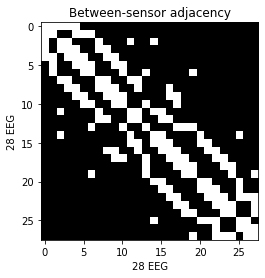

In [95]:
import matplotlib.pyplot as plt

# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(word_epochs.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [96]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 2.680168
stat_fun(H1): min=0.009550 max=16.185654
Running initial clustering
Found 39 clusters
Permuting 999 times...


/tmp/ipykernel_392/1839925267.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [97]:
print(p_values)
print(good_cluster_inds)

[1.    1.    1.    0.999 0.996 1.    1.    1.    1.    1.    0.904 1.
 1.    1.    0.97  1.    1.    1.    1.    1.    1.    0.998 0.874 1.
 0.228 0.784 1.    1.    0.001 1.    1.    0.822 0.781 1.    0.997 1.
 1.    1.    0.999]
[28]


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


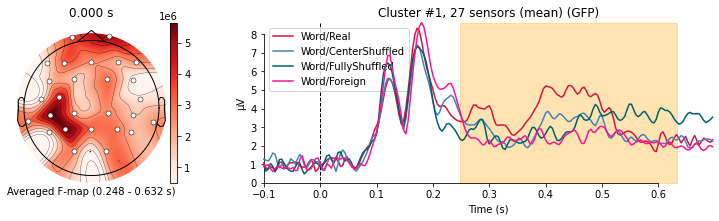

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
colors = {"Word/Real": "crimson", "Word/CenterShuffled": 'steelblue', "Word/FullyShuffled": "#005f6a", "Word/Foreign": "#FF1493"}

# organising data for plotting
evokeds = {cond: word_epochs[cond].average() for cond in ["Word/Real", "Word/CenterShuffled", "Word/FullyShuffled", "Word/Foreign"]} 

# looping over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpacking cluster information
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # getting signals at the sensors contributing to the cluster
    sig_times = word_epochs.times[time_inds]

    # creating spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialising the figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plotting average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], word_epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # creating additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # adding axes for colourbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # adding new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plotting temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean-up
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()

This is the only cluster in which we see a significant difference between any two of the conditions. The statistically significant diffference occurs in the yellow window. This cluster is based on 27 (!!!) of the 28 sensors.

## Windowed mean
One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1) Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature. 
2) Taking the mean of that window across channels and and samples.
3) Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant, we can keep one dimension of the individual data, i.e. the trials.

### T-test
We can now do a t-test on the trials from the two conditions, to establish whether the means of the two groups are statistically significant.

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.

#### Create ANOVA Test Function

In [99]:
def Anova_Epochs(Epoch_Condition, tmin, tmax, channels):
    n_conditions = range(len(Epoch_Condition))
    data = []
    for i in n_conditions:
        data.append(Epoch_Condition[i].get_data(picks=channels, tmin=tmin, tmax=tmax))
    
    means = []
    for i in n_conditions:
        mean_temp = np.mean(data[i], axis=2)
        means.append(np.mean(mean_temp, axis=1))
    
    return st.f_oneway(*means)        

In [100]:
# First we run at a time window around 130 ms - the first peak of interest
print(Anova_Epochs(Epoch_Condition = [word_real_epochs, word_foreign_epochs, word_cs_epochs, word_fs_epochs], 
             tmin = .115, 
             tmax = .135,
             channels = ['P3', 'P7', 'O1', 'P8']))

# Then we run at a time window around 190 ms - the second peak of interest
print(Anova_Epochs(Epoch_Condition = [word_real_epochs, word_foreign_epochs, word_cs_epochs, word_fs_epochs], 
             tmin = .175, 
             tmax = .19,
             channels = ['P3', 'P7', 'O1', 'P8']))

# Then we run at a time window around 230 ms - the third peak of interest
print(Anova_Epochs(Epoch_Condition = [word_real_epochs, word_foreign_epochs, word_cs_epochs, word_fs_epochs], 
             tmin = .225, 
             tmax = .240,
             channels = ['P3', 'P7', 'O1', 'P8']))

F_onewayResult(statistic=2.2075027580446642, pvalue=0.09073856015960305)
F_onewayResult(statistic=1.2840739965036247, pvalue=0.2830283076578006)
F_onewayResult(statistic=1.6974358666310665, pvalue=0.1712226311358903)


### Create T-Test Function

In [101]:
def Ttest_Epochs(Epoch_Condition, tmin, tmax, channels):
    data = []
    for i in range(2):
        data.append(Epoch_Condition[i].get_data(picks=channels, tmin=tmin, tmax=tmax))
    
    means = []
    for i in range(2):
        mean_temp = np.mean(data[i], axis=2)
        means.append(np.mean(mean_temp, axis=1))
    
    return st.ttest_ind(a=means[0], b=means[1])  

In [102]:
Ttest_Epochs(Epoch_Condition = [word_real_epochs, word_foreign_epochs], 
             tmin = .115, 
             tmax = .135,
             channels = ['P3', 'P7', 'O1', 'P8'])


Ttest_indResult(statistic=-1.7456879113113013, pvalue=0.08598413519714884)

### Pairwise T-tests in The Significant Window

In [176]:
def pairwise_Ttest(Epoch_Condition, tmin, tmax, channels, Epoch_Names):
    n_conditions = range(len(Epoch_Condition))
    data = []
    for i in n_conditions:
        data.append(Epoch_Condition[i].get_data(picks=channels, tmin=tmin, tmax=tmax))
    
    means = []
    for i in n_conditions:
        mean_temp = np.mean(data[i], axis=2)
        means.append(np.mean(mean_temp, axis=1))
    
    ## create empty lists
    pairwise_names = []
    pairwise_pval = []
    pairwise_tstat = []
    
    ## make all the combinations
    for a, b in combinations(Epoch_Names, 2): 
        y = f"{a} vs. {b}"
        pairwise_names.append(y)
        
    for a, b in combinations(means, 2): # function which make all combinations of 2 means possible
        y = st.ttest_ind(a, b)
        pairwise_pval.append(y.pvalue)
        pairwise_tstat.append(y.statistic)
    
    
    bonferroni = multi(pairwise_pval, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    
    ## create dataframe
    data = pd.DataFrame({"Comparison":pairwise_names, "P-Value":pairwise_pval, "t-statistic":pairwise_tstat, "Bonferroni Adj.":bonferroni[1]})
    
    return data
    

In [179]:
pairwise = pairwise_Ttest(Epoch_Condition = [word_real_epochs, word_foreign_epochs, word_cs_epochs, word_fs_epochs], 
             tmin = .248, 
             tmax = .632,
             channels = ['P3', 'P7', 'O1', 'P8'],
             Epoch_Names = ["Real", "Foreign", "CS", "FS"]
              )

pairwise

,Comparison,P-Value,t-statistic,Bonferroni Adj.
0,Real vs. Foreign,0.009600,-2.675678,0.057597
1,Real vs. CS,0.238917,-1.189529,1.000000
2,Real vs. FS,0.001365,-3.358666,0.008191
3,Foreign vs. CS,0.191861,1.319963,1.000000
4,Foreign vs. FS,0.463686,-0.737511,1.000000
5,CS vs. FS,0.050649,-1.994482,0.303892
